In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.optim import Adam

In [15]:
#import the data
# N,feature_dim
representations = torch.load("originals.pt")

#augmented representations 
#achieved by applying augmentation T(x) to each x and saving the corresponding
#representations, there is N,num_aug,feature_dim
representations_aug = torch.load("augmentations.pt")

#labels N, not uniform
labels = torch.load("labels.pt")

#100 nearest neighbor (idx) for each 'i' in representations
#doesn't include i itself
knn_indices = torch.load("nn_indices.pt")

print(f"representations.shape: {representations.shape}")
print(f"representations_aug.shape: {representations_aug.shape}")
print(f"labels.shape: {labels.shape}")
print(f"knn_indices.shape: {knn_indices.shape}")

#might want to work with unit vectors
repr_norm = representations/torch.norm(representations,dim=-1,keepdim=True)
repr_aug_norm = representations_aug/torch.norm(representations_aug,dim=-1,keepdim=True)

representations.shape: torch.Size([42443, 512])
representations_aug.shape: torch.Size([42443, 10, 512])
labels.shape: torch.Size([42443])
knn_indices.shape: torch.Size([42443, 100])


In [19]:
#dimensionality reduction representations
pca_model = PCA(n_components=2)
pca_emb =pca_model.fit_transform(repr_norm)
umap_model = umap.UMAP(n_components=2,random_state=42)
umap_emb = umap_model.fit_transform(repr_norm)
print("UMAP done")
tsne_model = TSNE(n_components=2,random_state=42)
tsne_emb = tsne_model.fit_transform(repr_norm)
print("TSNE done")

/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP done
TSNE done


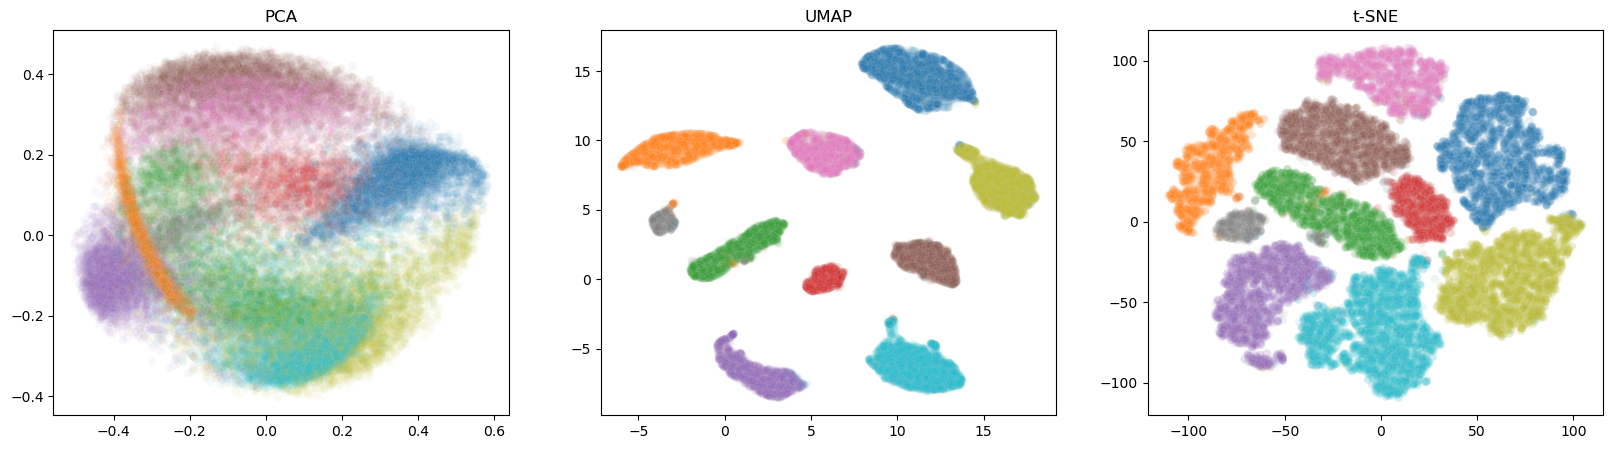

In [28]:
f,a = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(x=pca_emb[:,0],y=pca_emb[:,1],hue=labels,palette="tab10",alpha=0.05,ax=a[0],legend=False)
sns.scatterplot(x=umap_emb[:,0],y=umap_emb[:,1],hue=labels,palette="tab10",alpha=0.05,ax=a[1],legend=False)
sns.scatterplot(x=tsne_emb[:,0],y=tsne_emb[:,1],hue=labels,palette="tab10",alpha=0.05,ax=a[2],legend=False)
a[0].set_title("PCA")
a[1].set_title("UMAP")
a[2].set_title("t-SNE")
plt.show()

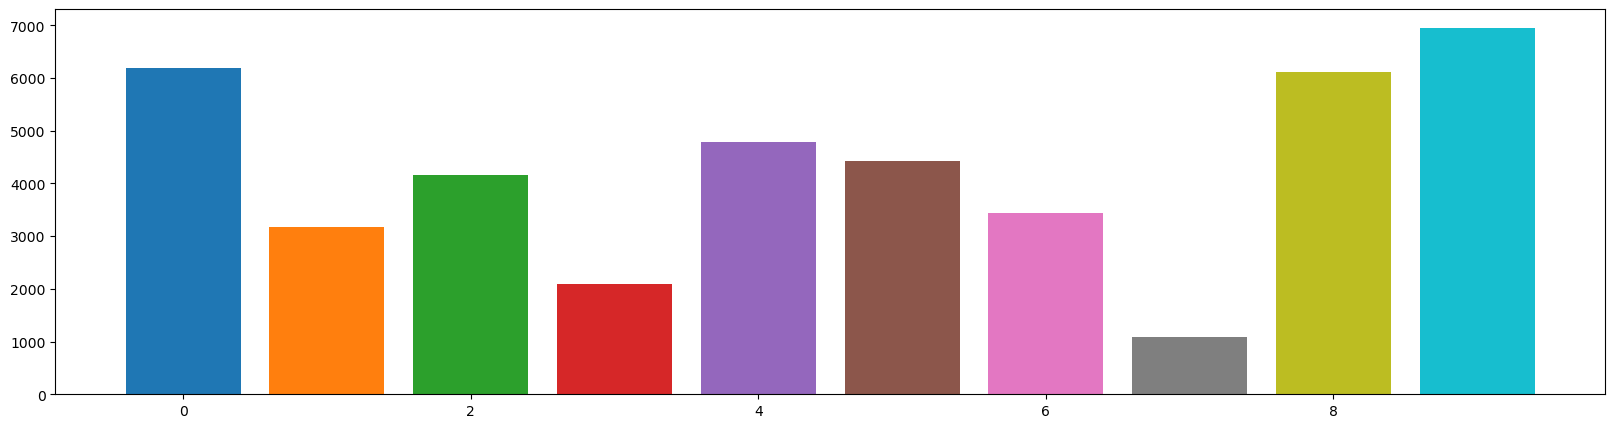

In [27]:
f,a = plt.subplots(1,1,figsize=(20,5))
colors = plt.cm.tab10(range(10))
#for loop to get the colors for each bin
for i in range(10):
    a.bar(i,(labels==i).int().sum(),color=colors[i])

In [37]:
class Classifier(nn.Module):
    def __init__(self,K=10,input_dim=512,hidden_dim=1024):
        super(Classifier,self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,K)
        )

    def forward(self,x):
        return self.classifier(x)
    


In [38]:
from torch.utils.data import Dataset, DataLoader

#if you want to write a custom dataset to fetch 
#either pairs, original or augmented do it here
#the dataloader will call the __getitem__ method

class CustomDataset(Dataset):
    def __init__(self,representations,labels,knn_indices,repr_aug=None):
        self.representations = representations
        self.labels = labels
        self.knn_indices = knn_indices
        self.repr_aug = repr_aug
        self.num_aug = self.repr_aug.shape[1]
        self.num_neighbors = self.knn_indices.shape[1]

    def __len__(self):
        return self.representations.shape[0]
    
    def __getitem__(self,idx):
    
        #get the original x,y
        x = self.representations[idx]
        y = self.labels[idx]

        #randomly sample a neighbor or an augmentation to return
        i = torch.randperm(self.num_aug)[0]
        j = torch.randperm(self.num_neighbors)[0]

        augment_x = self.repr_aug[idx,i]
        neighbor_x = self.representations[self.knn_indices[idx,j]]

        return x,augment_x,neighbor_x,y
    
dataset = CustomDataset(representations,labels,knn_indices,representations_aug)
dataloader = DataLoader(dataset,batch_size=500,shuffle=True)
batch = next(iter(dataloader))
x,x_aug,x_neigh,y = batch

In [39]:
def loss_function(p1,p2,lamb=1.0,tau=1.0):

    p1 = F.softmax(p1,dim=-1)
    p2 = F.softmax(p2,dim=-1)

    #write loss function here
    loss=0

    return loss

In [ ]:
model = Classifier()
device = 'cuda'
model.to(device)
optimizer = Adam(model.parameters(),lr=0.001)
epochs = 20

In [ ]:
#write your own training loop here

tqdm = tqdm(range(epochs))
losses = []
for epoch in tqdm:

    for batch in dataloader:

        optimizer.zero_grad()
        #move things to device
        #x,x_aug,x_neigh,y = batch
        #x,x_aug,x_neigh,y = x.to(device),x_aug.to(device),x_neigh.to(device),y.to(device)
        p1 = model(x)
        p2 = model(other_x)

        loss = loss_function(p1,p2)
        loss.backward()
        optimizer.step()        
        losses.append(loss.item())


In [42]:
#run eval
model.eval()
dataloader = DataLoader(dataset,batch_size=500,shuffle=False)

predictions = []
with torch.no_grad():
    for batch in dataloader:
        x,x_aug,x_neigh,y = batch
        
        x = x.to(device)
        p1 = model(x)
        predictions.append(p1.cpu().argmax(dim=-1))

predictions = torch.cat(predictions)

In [ ]:
#view how the predictions look in embedding space
sns.scatterplot(x = umap_emb[:,0],
                y = umap_emb[:,1],
                hue = predictions,
                palette="tab10")